In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import numpy as np

import torch
from torch import Tensor
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn import Module

import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

mpl.rcParams['xtick.major.size'] = 20
mpl.rcParams['xtick.major.width'] = 4
mpl.rcParams['xtick.minor.size'] = 10
mpl.rcParams['xtick.minor.width'] = 2

mpl.rcParams['ytick.major.size'] = 20
mpl.rcParams['ytick.major.width'] = 4
mpl.rcParams['ytick.minor.size'] = 10
mpl.rcParams['ytick.minor.width'] = 2

In [3]:
from srnn import SRNN
from lossFunctions import LossTargets
from activationFunctions import Tanh_shifted_and_scaled

In [4]:
# BUILD A TEST SRNN

f = 0.05

init_info = dict(N=100, 
                 f = f, 
                 activation=Tanh_shifted_and_scaled(),
                 J_init_type='covariance',
                 dt=0.1,
                 x_init=None,
                 verbose=True,
                 GPU=None)

input_info = dict(alpha=0.5,
                  P=None,
                  ON_time=10,)

targets = np.ones([2,20])
targets[0,:] = 0.015
targets[1,:] = 0.01
output_info = dict(targets=targets,
                   learn_readout=False,
                   start_id=10,
                   f_out=f,)

training_info = dict(learning_rate=1,
                     loss_fn=LossTargets(),
                     N_epochs=100,
                     stopping_accuracy=0.99)

example_SparseRNN = SRNN(init_info=init_info, 
                         input_info=input_info, 
                         output_info=output_info, 
                         training_info=training_info,)

ids_plus  = example_SparseRNN.ids_positive_label
ids_minus = example_SparseRNN.ids_negative_label

In [5]:
pre_training_readout = example_SparseRNN(100).T.detach().numpy()

In [6]:
example_SparseRNN.train_model()

Epoch 0. Elapsed time: 1.37 s. Maximum accuracy so far: 50.40%.
Epoch 1. Elapsed time: 1.53 s. Maximum accuracy so far: 51.60%.
Epoch 2. Elapsed time: 1.45 s. Maximum accuracy so far: 52.40%.
Epoch 3. Elapsed time: 1.38 s. Maximum accuracy so far: 52.80%.
Epoch 4. Elapsed time: 1.39 s. Maximum accuracy so far: 52.80%.
Epoch 5. Elapsed time: 1.39 s. Maximum accuracy so far: 52.80%.
Epoch 6. Elapsed time: 1.39 s. Maximum accuracy so far: 53.60%.
Epoch 7. Elapsed time: 1.39 s. Maximum accuracy so far: 55.20%.
Epoch 8. Elapsed time: 1.38 s. Maximum accuracy so far: 57.20%.
Epoch 9. Elapsed time: 1.38 s. Maximum accuracy so far: 58.00%.
Epoch 10. Elapsed time: 1.38 s. Maximum accuracy so far: 58.80%.
Epoch 11. Elapsed time: 1.39 s. Maximum accuracy so far: 59.60%.
Epoch 12. Elapsed time: 1.39 s. Maximum accuracy so far: 59.60%.
Epoch 13. Elapsed time: 1.38 s. Maximum accuracy so far: 59.60%.
Epoch 14. Elapsed time: 1.38 s. Maximum accuracy so far: 60.00%.
Epoch 15. Elapsed time: 1.38 s. Max

In [7]:
post_training_readout = example_SparseRNN(100).T.detach().numpy()

# Before Training

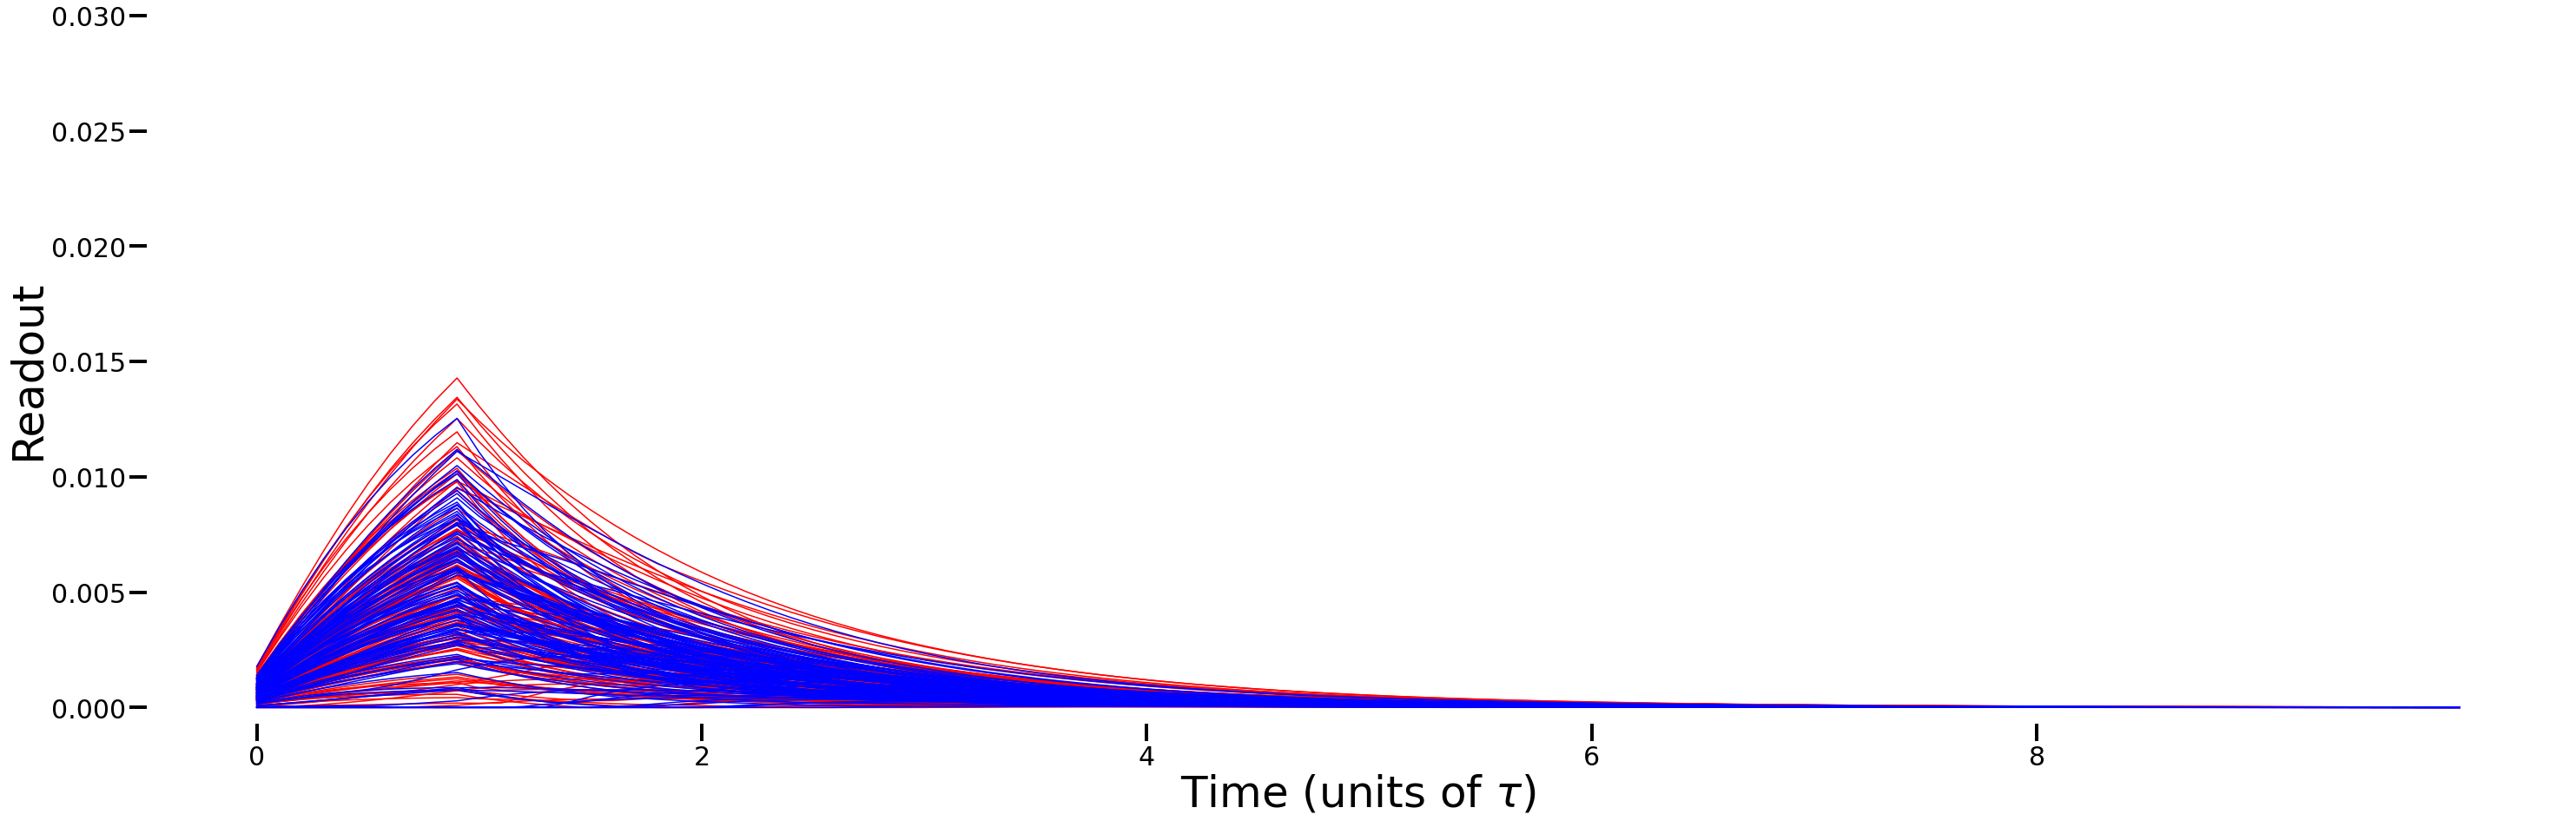

In [8]:
plt.figure(figsize=(50,15))
plt.plot(pre_training_readout[:,ids_plus]*f, 'r')
plt.plot(pre_training_readout[:,ids_minus]*f, 'b')
plt.xticks(np.arange(0,100,20), np.arange(0,10,2), fontsize=30)
plt.yticks(np.arange(0,0.031,0.005), fontsize=30)
plt.xlabel(r'Time (units of $\tau$)', fontsize=50)
plt.ylabel('Readout', fontsize=50)
plt.box(False)
plt.show()

# After Training

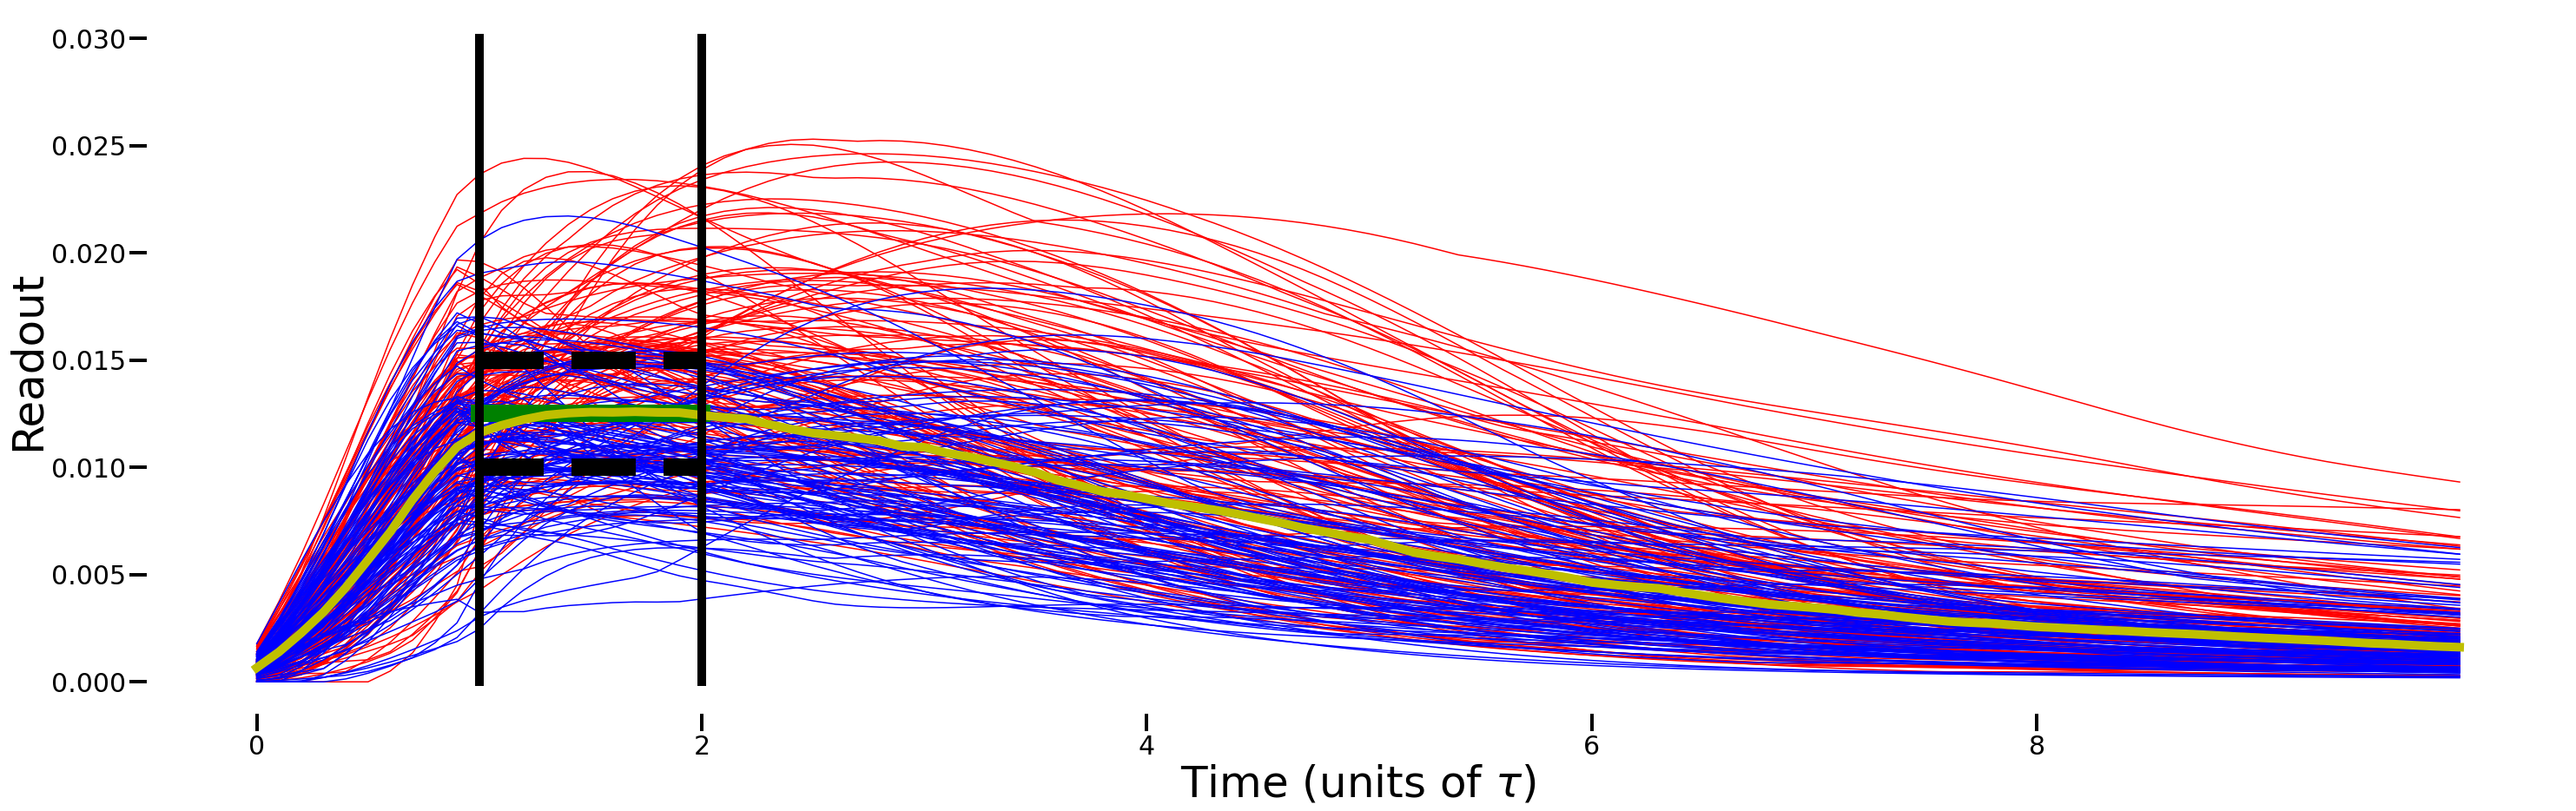

In [9]:
plt.figure(figsize=(50,15))
plt.plot(post_training_readout[:,ids_plus]*f, 'r')
plt.plot(post_training_readout[:,ids_minus]*f, 'b')
plt.plot([10,20],[targets[:,0].mean(), targets[:,0].mean()],'g', linewidth=20)
plt.plot([10,20],[targets[0,0], targets[0,0]],'k--', linewidth=20)
plt.plot([10,20],[targets[1,0], targets[1,0]],'k--', linewidth=20)
plt.plot(np.percentile(post_training_readout*f, 50, 1), 'y', linewidth=10)
plt.plot([10,10,],[0., 0.03],'k', linewidth=10)
plt.plot([20,20,],[0., 0.03],'k', linewidth=10)
plt.xticks(np.arange(0,100,20), np.arange(0,10,2), fontsize=30)
plt.yticks(np.arange(0,0.031,0.005), fontsize=30)
plt.xlabel(r'Time (units of $\tau$)', fontsize=50)
plt.ylabel('Readout', fontsize=50)
plt.box(False)
plt.show()

# Accuracy in time post Training
[based on dynamically computed, non-constant in time, threshold (yellow continuous line in above figure)]

Note that accuracy decays after time 2*tau since that region is outside the trainind regime.

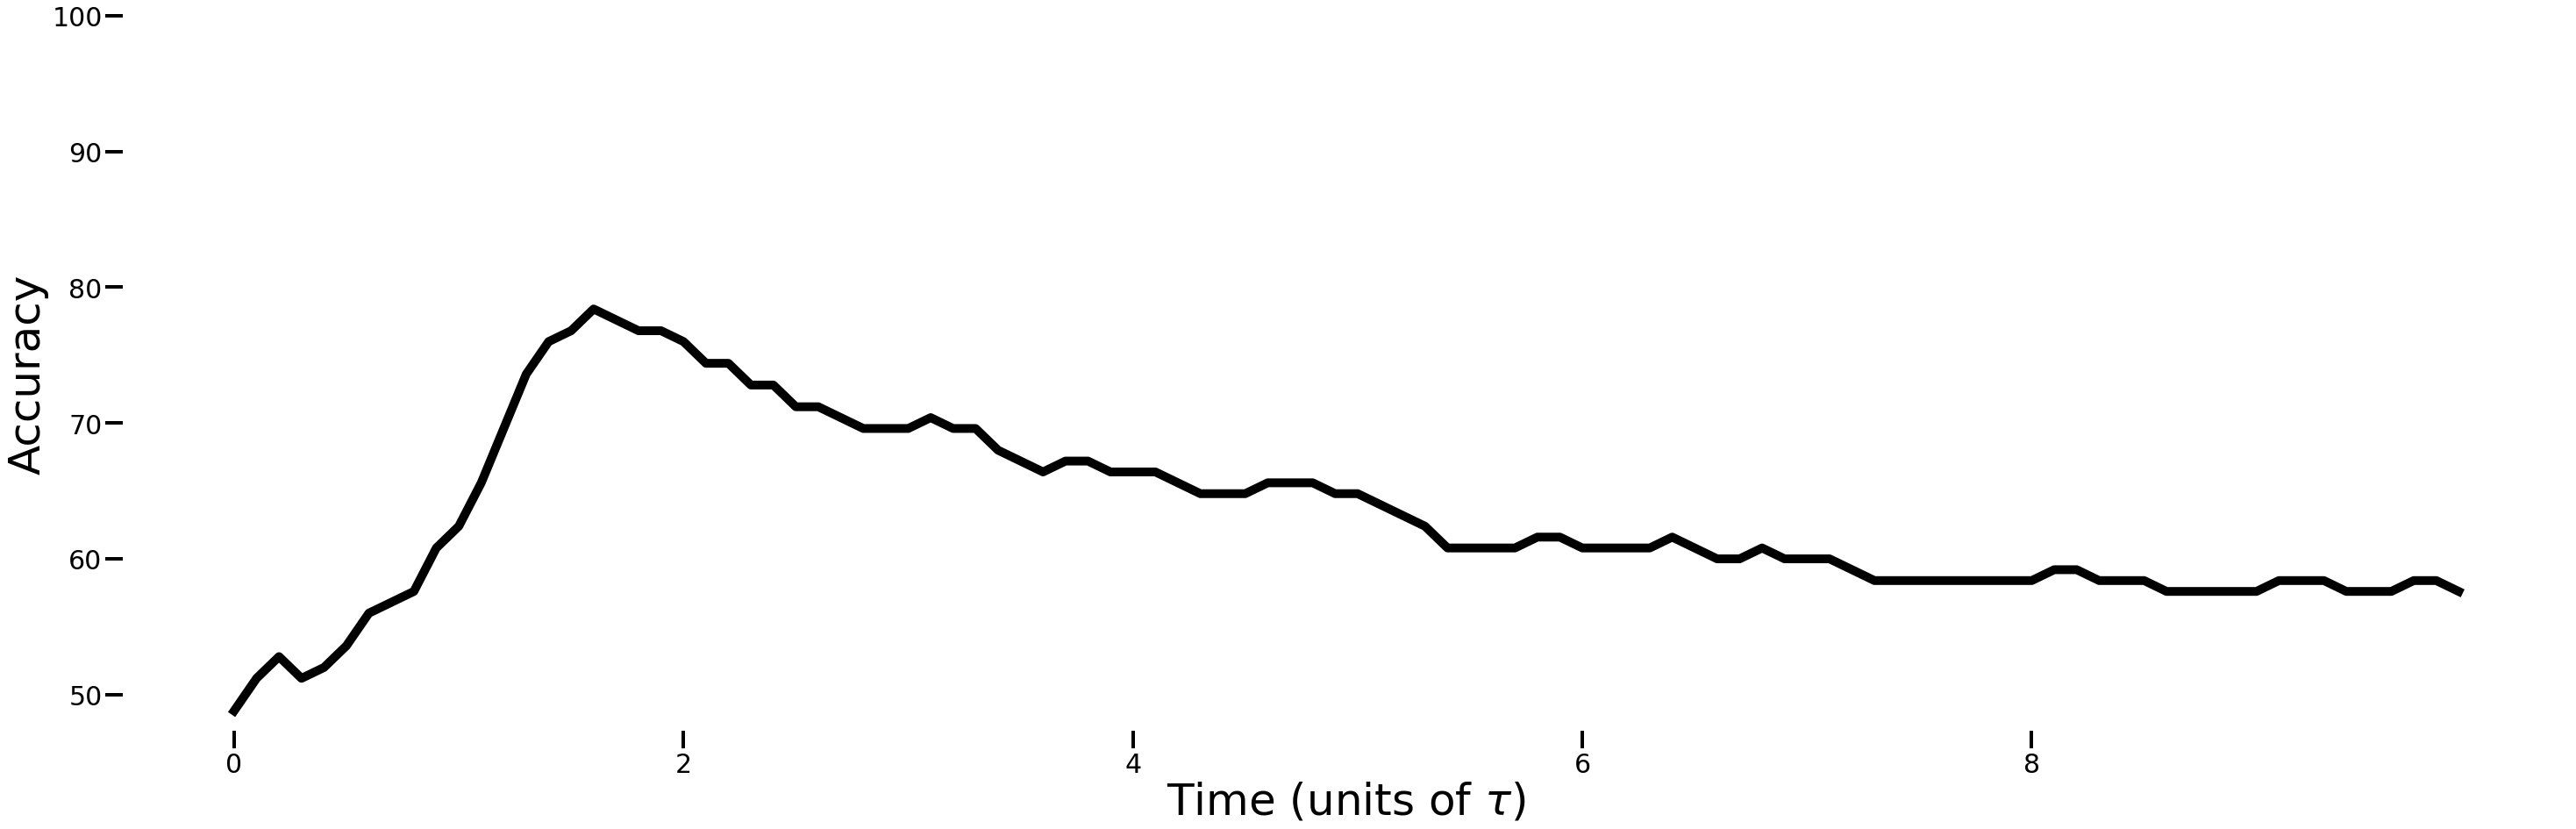

In [10]:
accuracy_in_time = ((post_training_readout.T > np.percentile(post_training_readout, ids_minus.shape[0]/(ids_minus.shape[0] + ids_plus.shape[0])*100, 1)) * 2 - 1).T
accuracy_in_time = (accuracy_in_time * example_SparseRNN.labels.numpy() > 0).sum(1) / (ids_minus.shape[0] + ids_plus.shape[0])*100
plt.figure(figsize=(50,15))
plt.plot(accuracy_in_time, 'k', linewidth=10)

plt.xticks(np.arange(0,100,20), np.arange(0,10,2), fontsize=30)
plt.yticks(np.arange(50,101,10), fontsize=30)
plt.xlabel(r'Time (units of $\tau$)', fontsize=50)
plt.ylabel('Accuracy', fontsize=50)
plt.box(False)
plt.show()

### Sample connections per neuron

In [11]:
print((list(example_SparseRNN.J.parameters())[0]._indices()[0,:] == 64).sum())
print((list(example_SparseRNN.J.parameters())[0]._indices()[1,:] == 64).sum())
print()
print((list(example_SparseRNN.J.parameters())[0]._indices()[0,:] == 72).sum())
print((list(example_SparseRNN.J.parameters())[0]._indices()[1,:] == 72).sum())

tensor(7)
tensor(4)

tensor(4)
tensor(5)


### Number of readout neurons

In [12]:
print(list(example_SparseRNN.w_out.parameters())[0]._indices().shape[1])

5
